In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
# Gloabal Constants
pass_file = "/mnt/data/mvesc/pgpass" # username, db information

# Table names
sqlcmd_table_names = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

Tab_CurrentStudents = "CurrentStudents"
Tab_AllDis1112 = "AllDistricts1112"
Tab_AllDis1213 = "AllDistricts1213"
Tab_AllDis1314 = "AllDistricts1314"
Tab_AllDis1515 = "AllDistricts1415"

# The table names in a string, from Jackie
ALL_DISTRICTS_TABLES = ["AllDistricts" + str(num-1) + str(num) for num in range(15,11, -1)]
ALL_DISTRICTS_TABLES.insert(0, "CurrentStudents")
# ['CurrentStudents', 'AllDistricts1112', 'AllDistricts1213', 'AllDistricts1314', 'AllDistricts1415']

Tab_HSGrades = "HSGrades"

In [3]:
# Set up connection to postgres database
with open(pass_file, 'r') as f:
    passinfo = f.read()
passinfo = passinfo.strip().split(':')

host_address = passinfo[0]
user_name = passinfo[2]
name_of_database = passinfo[3]
user_password = passinfo[4]
connection = pg.connect(host=host_address, database=name_of_database, user=user_name, password=user_password)
cursor = connection.cursor()
table_names = pd.read_sql(sqlcmd_table_names, connection)
print(table_names)

                  table_name
0          DistrictSchoolIDs
1            CurrentMobility
2            CurrentStudents
3              ASQ_Preschool
4                  ActScores
5           AllDistricts1112
6                   HSGrades
7           AllDistricts1213
8                  AIRScores
9           AllDistricts1314
10  CurrentAbsenceDiscipline
11                  DIBELSv2
12          AllDistricts1415
13             AllGradsTotal
14                    OAAOGT
15                     PARCC
16                  StarRead
17                    StarEL
18                  StarMath
19                 TerraNova


In [5]:
# functions explore a table
def get_column_names(table, connection):
    """
    Get column names of a table 
    
    :param pg.extensions.connection object connection: sql connection
    :param string table: table name in the database
    :rtype: list 
    """
    temp_table = pd.read_sql("select * FROM \"%s\" limit 1" % table, connection)
    return list(temp_table.columns)

def read_table_to_df(table_name, connection, maxStudentLookup=1e6):
    """ from Jackie
    Takes a table name as input and returns postgres table as pandas data frame.
    
    :param string table_name: Name of table to read in
    :param psycopg2.connection connection: POSTGRESQL connection object for Python
    :return: a Pandas dataframe object containing the desired table
    :rtype: Pandas.dataframe
    """
    sql_query = "SELECT * FROM \"" + table_name + "\";"
    data = pd.read_sql(sql_query, connection)
    return data

def different_columns(table1, table2, connection):
    """ find different columns names of two tables
    
    :param string table1: name of table 1
    :param string table2: name of table 2
    :param pg.connection connection: sql connection
    :return: a list with 2 sets of different columns names in 2 tables
    :rtype: list[set, set]
    """
    columns1 = get_column_names(table1, connection)
    columns2 = get_column_names(table2, connection)
    diff_col1 = set(columns1) - set(columns2)
    diff_col2 = set(columns2) - set(columns1)
    return([diff_col1, diff_col2])

def generate_colnames(schoolyear='1415'):
    """ generate the colnames based on the shcool year, e.g. 1415
    
    :para string schoolyear: school year, e.g. 1415
    :return: a list of columns names
    :rtype: list[string]
    """
    columns_name_base = ['StudentLookup', 'CURRENT_GRADE', 'HANDICAP', 'HANDICAP_DESC', 'DISADVANTAGEMENT', 'DISADVANTAGEMENT_DESC', 'DATE_OF_BIRTH', 'STUDENT_STATUS', 'STUDENT_STATUS_DESC', 'GENDER', 'RACIAL_ETHNIC_DESC', 'LIMITED_ENGLISH', 'GIFTED', 'ADMISSION_DATE', 'PERCENT_ATTEND', 'DAYS_IN_ATTENDANCE', 'DAYS_ABSENT', 'TARDY', 'PERCENT_ATTEND', 'DAYS_IN_ATTENDANCE', 'DAYS_ABSENT', 'TARDY', 'DISC_INCIDENTS', 'IN_SCHOOL_SUSP', 'OUT_OF_SCHOOL_SUSP', 'EXPUL', 'District', 'School']
    current_year=int(schoolyear[-2:]) # last 2 characters of a table name
    year_append1 = "_20"+str(current_year-2)+"_"+str(current_year-1)
    year_append2 = "_20"+str(current_year-3)+"_"+str(current_year-2)
    year_append = [year_append1]*4 + [year_append2]*4 + [year_append1]*4
    col_append = ['']*14 + year_append + ['']*2
    columns = [columns_name_base[i]+col_append[i] for i in range(len(columns_name_base))]
    return(columns)

In [6]:
# Read all the data in a list 
# Old district data's first column ReCounter is dropped
NumStudent2Load = 1000
all_districts_data = [read_table_to_df(table_name, connection, NumStudent2Load).iloc[:, 1:] for table_name in ALL_DISTRICTS_TABLES[1:]]
all_districts_data.insert(0, read_table_to_df(ALL_DISTRICTS_TABLES[0], connection, NumStudent2Load))

In [37]:
# double check columns to see if they have the same structure
### What I learnt: the 5 tables have the same column names and data types ###
""" # check if tables have the same columns 
list_all_district_data_cols = [list(df.columns) for df in all_districts_data]
pd.DataFrame(np.transpose(np.array(list_all_district_data_cols)), columns=ALL_DISTRICTS_TABLES)
"""

''' # check if tables have the same data types
dtypes_all_districts_data=[[type(all_districts_data[i][col][0]) for col in all_districts_data[i].columns] for i in range(5)]
pd.DataFrame(np.transpose(np.array(dtypes_all_districts_data)), columns=ALL_DISTRICTS_TABLES)
'''

# check the data types for all columns
pd.DataFrame(np.transpose([list_all_district_data_cols[0], dtypes_all_districts_data[0]]), columns=['AllDistrictTable_columns', 'data_types'])


,AllDistrictTable_columns,data_types
0,StudentLookup,<class 'numpy.int64'>
1,CURRENT_GRADE,<class 'str'>
2,HANDICAP,<class 'str'>
3,HANDICAP_DESC,<class 'str'>
4,DISADVANTAGEMENT,<class 'str'>
5,DISADVANTAGEMENT_DESC,<class 'str'>
6,DATE_OF_BIRTH,<class 'pandas.tslib.Timestamp'>
7,STUDENT_STATUS,<class 'str'>
8,STUDENT_STATUS_DESC,<class 'str'>
9,GENDER,<class 'str'>


In [65]:
#col = [ row not in ['-2', '01'] for row in get_distinct_counts("CURRENT_GRADE", connection, Tab_AllDis1213).iloc[:,0]]
#get_distinct_counts("CURRENT_GRADE", connection, Tab_AllDis1213).iloc[col,:]

True

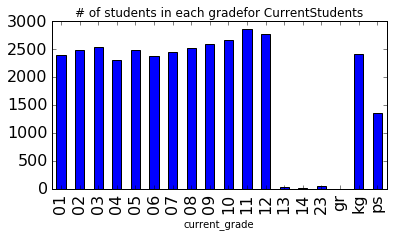

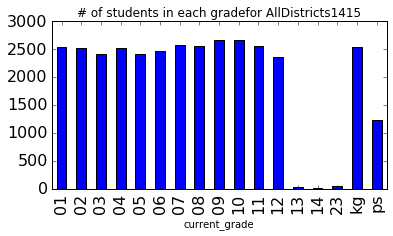

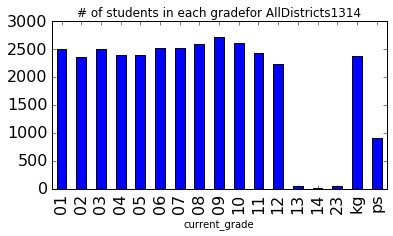

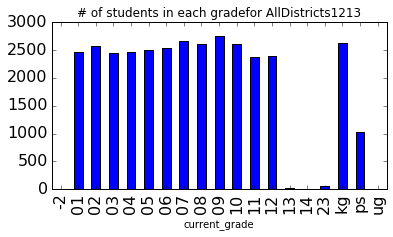

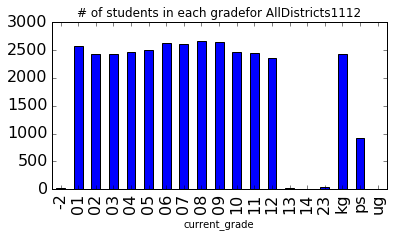

In [122]:
def get_distinct_counts(col, connection, table):
    """ get the number of dintinct values
    
    :param string col: column name
    :param pg.connection connection: sql connection
    :param string table: table name
    :return dataframe: data frame of distinct counts
    :rtype pandas.dataframe
    """
    cmd = "select lower(\"%s\") as %s, count(*) from \"%s\" group by lower(\"%s\") order by count(*) desc" % (col, col, table, col)
    df = pd.read_sql(cmd, connection)
    return df

def plot_group_counts(table, col, title='', out_rows=[], figsize=(6, 3)):
    """ get the number of students for each group
    
    :param string col: column name
    :param pg.connection connection: sql connection
    :param string table: table name
    :return dataframe: data frame of distinct counts
    :rtype pandas.dataframe
    """
    df = get_distinct_counts(col, connection, table)
    col = col.lower()
    df.index = df[col]
    row2keep = [row not in out_rows for row in df.iloc[:,0]]
    df = df.iloc[row2keep, :]
    df = df.sort_values([col])
    plt.figure()
    df['count'].plot(kind='bar', title=title + "for " + table, figsize=figsize, fontsize=16)

col='CURRENT_GRADE'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students in each grade')
    
### What I learnt: most students are in grade from 01 to 12
### Questions:??? what is -2, 13, 14, 23, GR, KG, PS
###:Cleanup: remove Grade '-2'

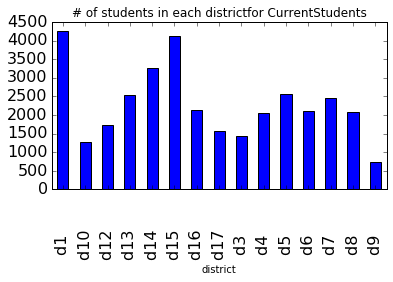

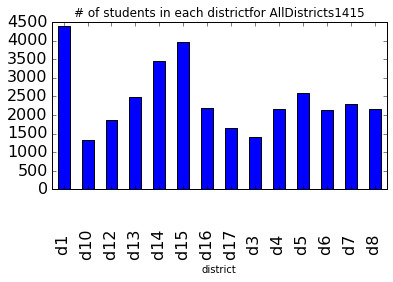

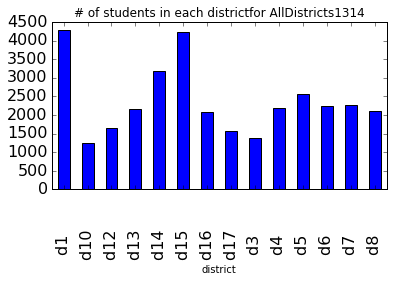

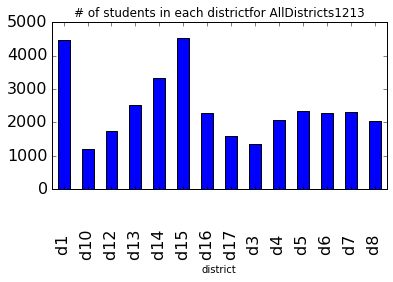

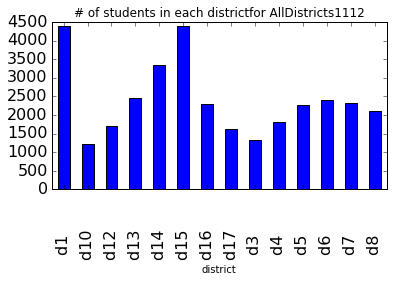

In [123]:
col='District'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students in each district')
    
### What I learnt: similar distributions; d9 is missing in AllDistrictData
### Questions:
### Cleanup: not much to do

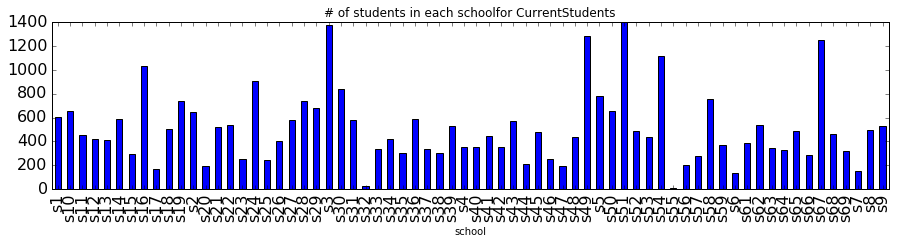

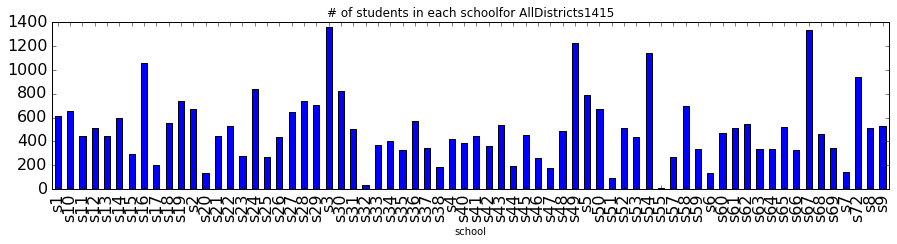

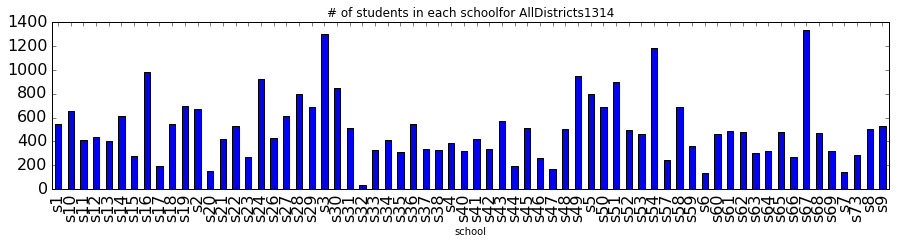

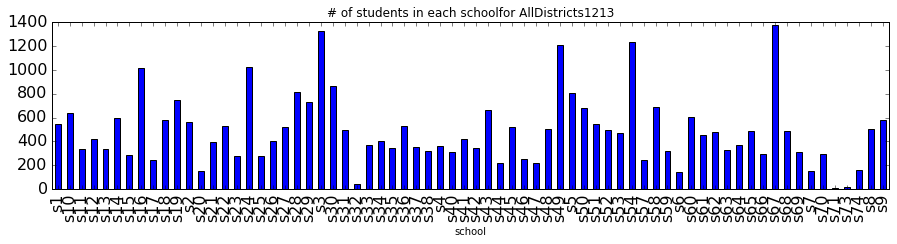

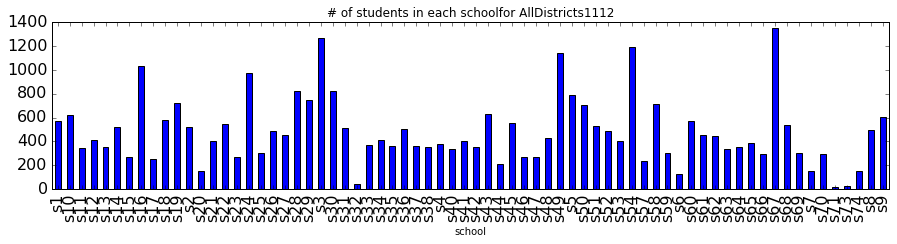

In [125]:
col='School'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students in each school', out_rows=[], figsize=(15,3))
    
### What I learnt: students in schools has similar distributions
### Questions:
### Cleanup: not much to do for this 

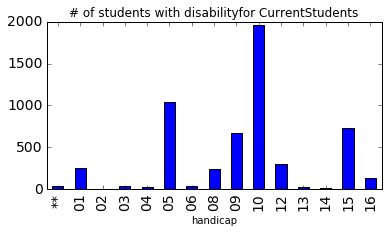

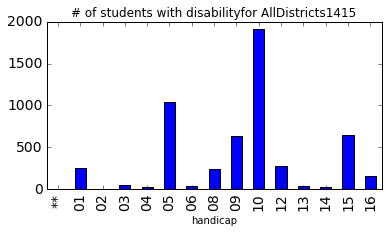

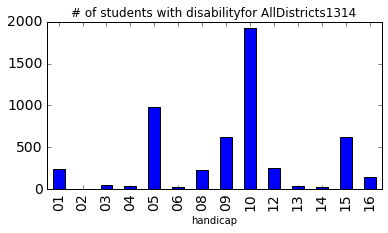

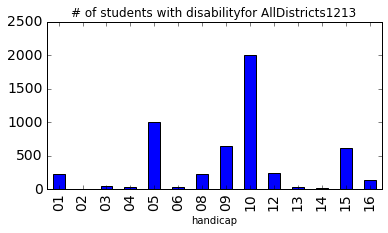

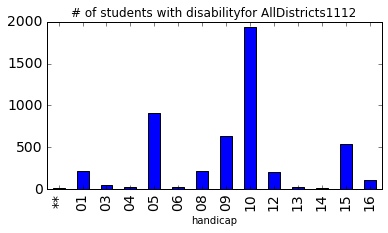

In [103]:
col='HANDICAP'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students with disability', out_rows=[''])
    
### what I learnt: similar distribution of "HANDICAP"; **, 02 has very few students; it could be a feature, maybe 2 classes
### Questions:??? **, 02 has no description
### cleanup: remove **, 05-Speech&Language, 13-Traumatic, some has code but no desc, some has desc but no code

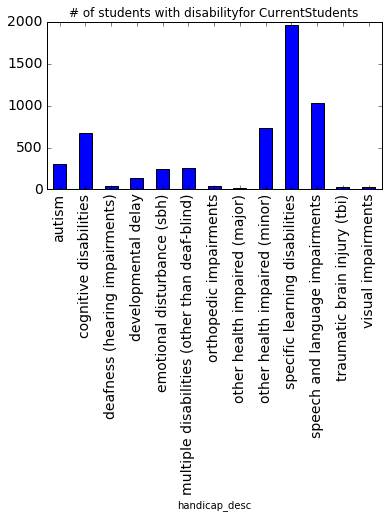

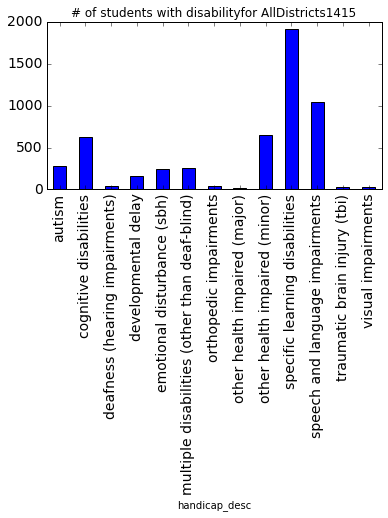

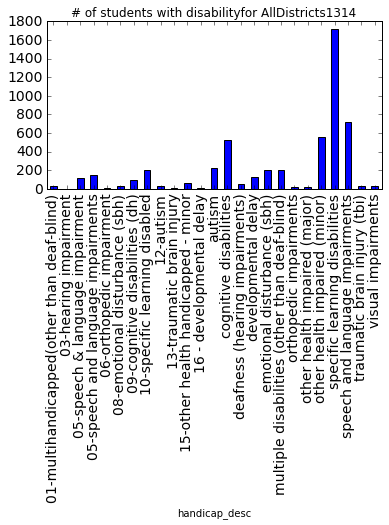

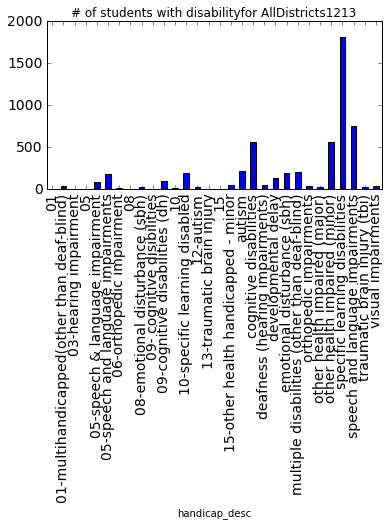

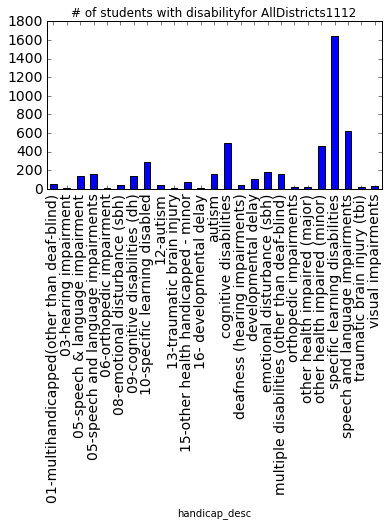

In [116]:
col='HANDICAP_DESC'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students with disability', out_rows=[''])
    
# What I learnt: very messy, code and desc are not consistent, some rows either code or desc are missing
# Question:
# cleanup: clean up the code and desc and redirect them to the right one for consistence

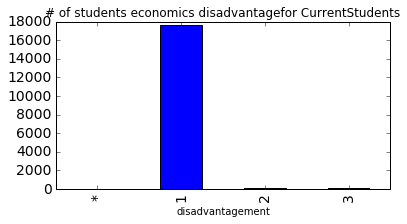

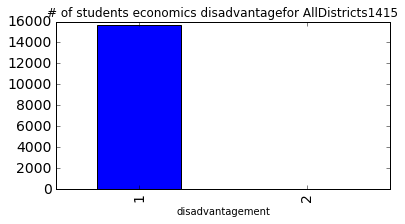

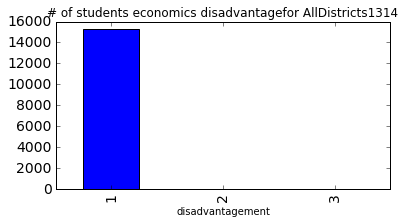

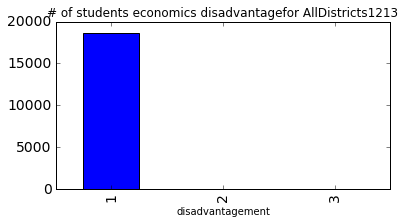

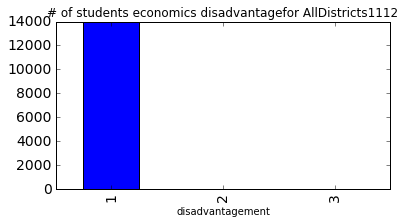

In [105]:
col='DISADVANTAGEMENT'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students economics disadvantage', out_rows=[''])
    
### what I learnt: Economic, Academic, Economic and Academic; could be a feature, only 3 classes, 
### Questions:??? blank code with Academic Disadvantages, 1-Economic, 2-AcademicDis, 25 * in currentstudent
### Clean up !!!: make code and desc consistent, Economic, *, blank code with Academic Disadvantages, 1-Economic, 2-AcademicDis, remove *'s

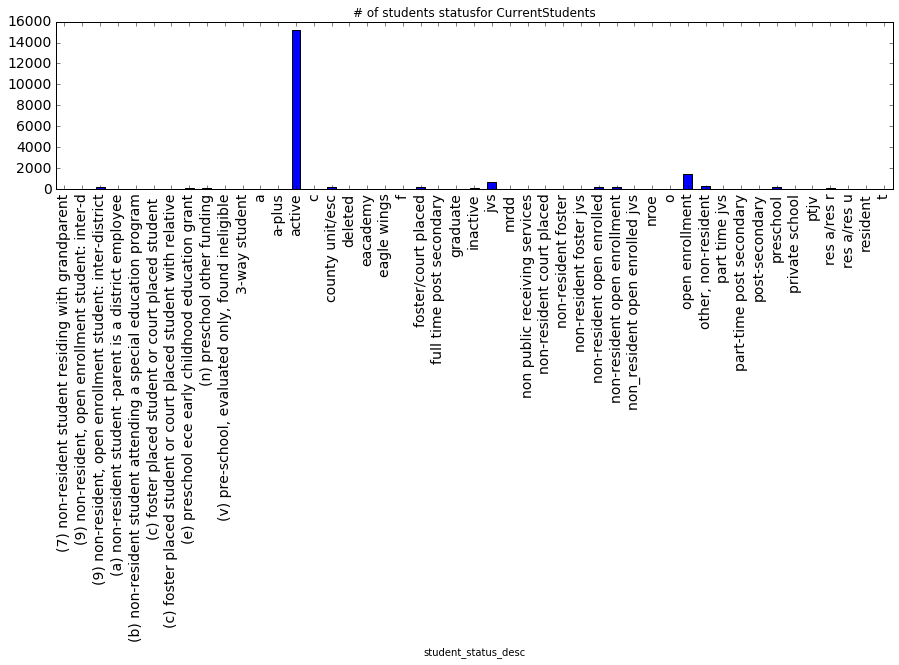

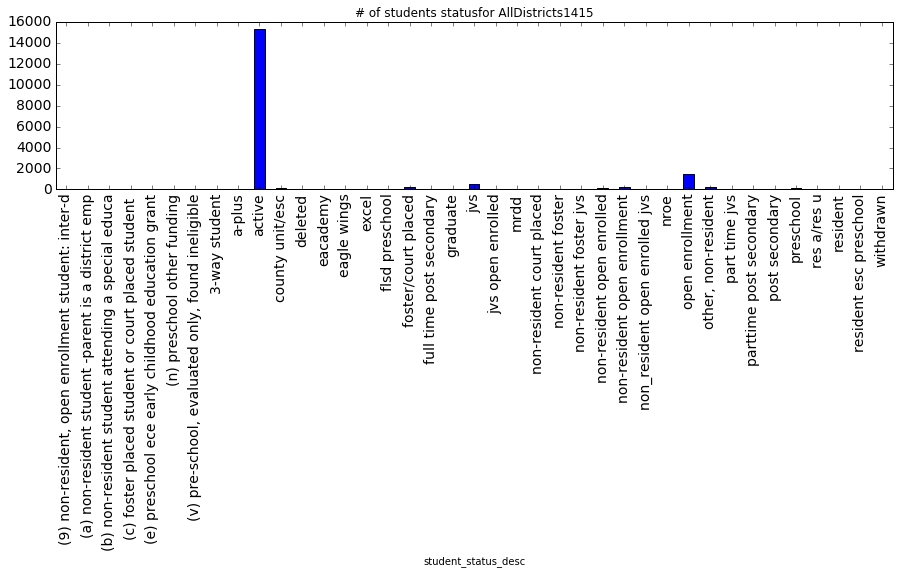

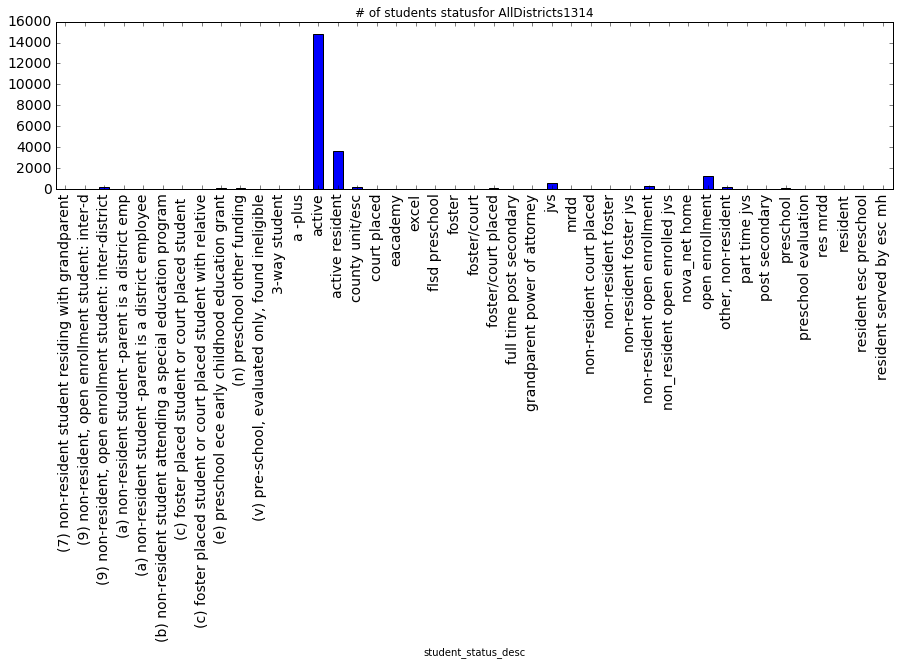

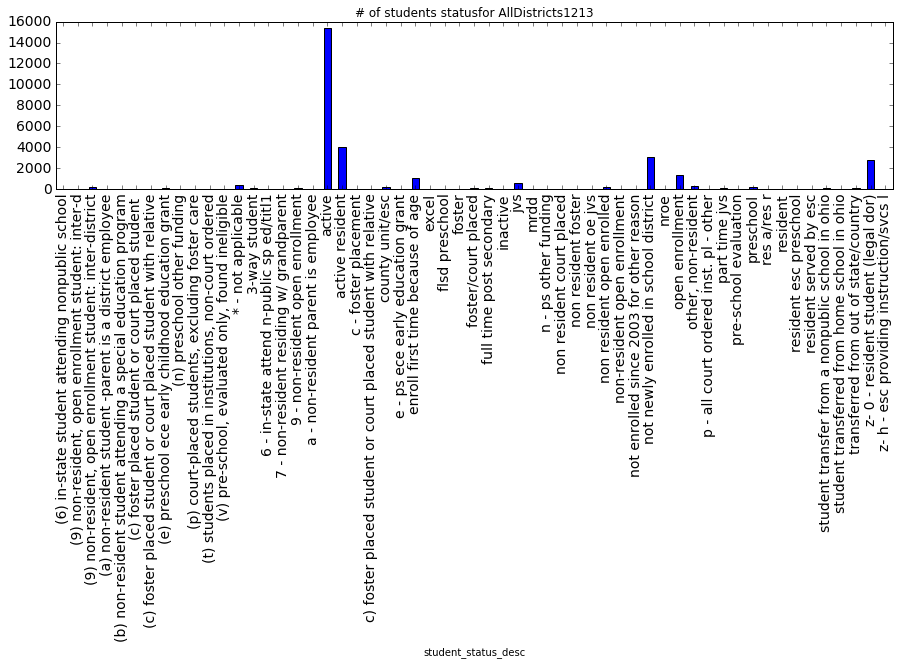

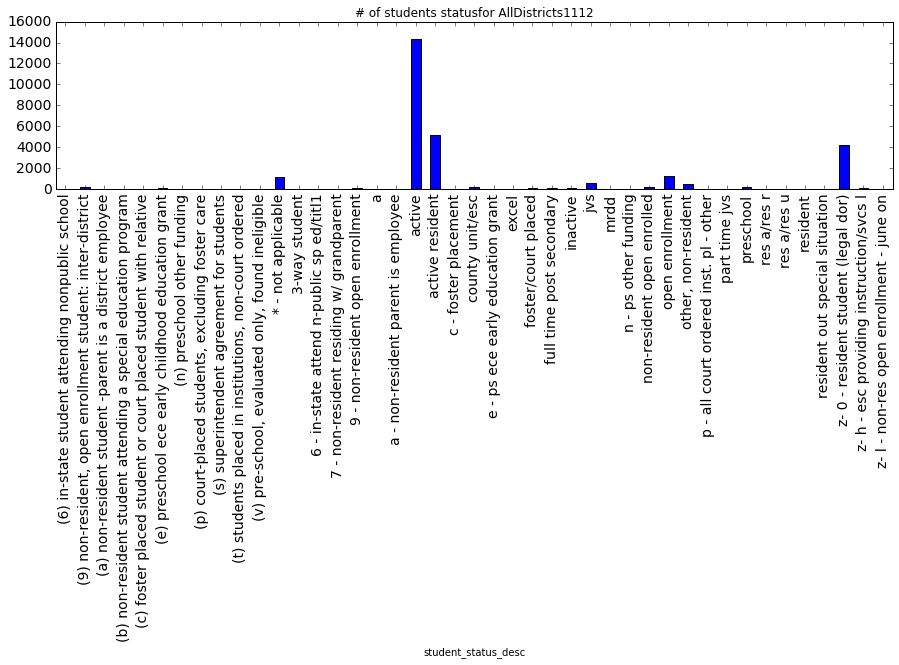

In [106]:
col='STUDENT_STATUS_DESC'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students status', out_rows=[''], figsize=(15, 3))
    
# what I learnt: very very messy, many categories
# Questions: 
# Cleanup: one of status or desc may be missing, code and desc may be in the same column

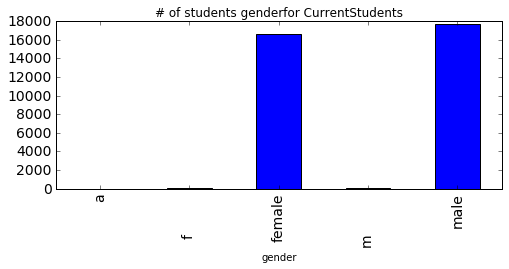

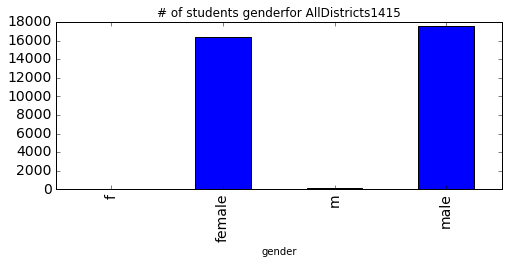

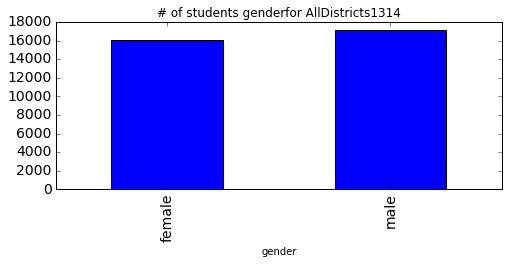

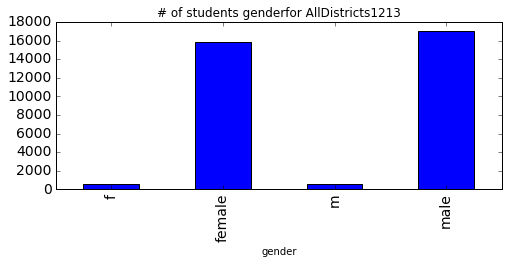

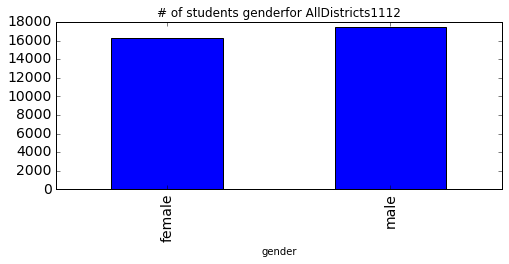

In [107]:
col='GENDER'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students gender', out_rows=[''], figsize=(8, 3))
    
# what I learnt: Gender; could be a feature 
# Questions: 
# Cleanup: lower/upper case; F-> female; M-> male;

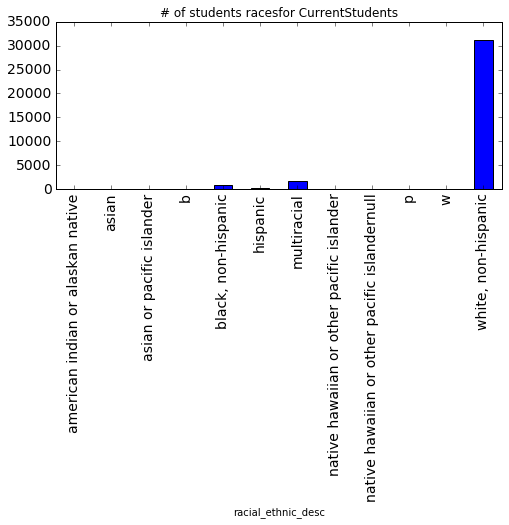

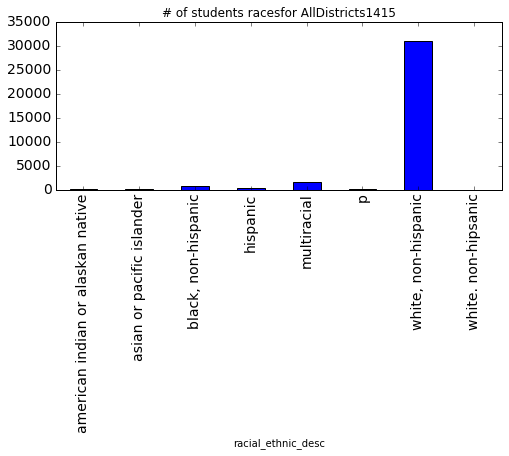

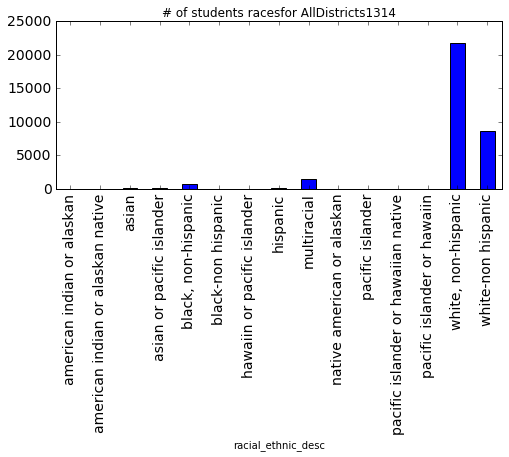

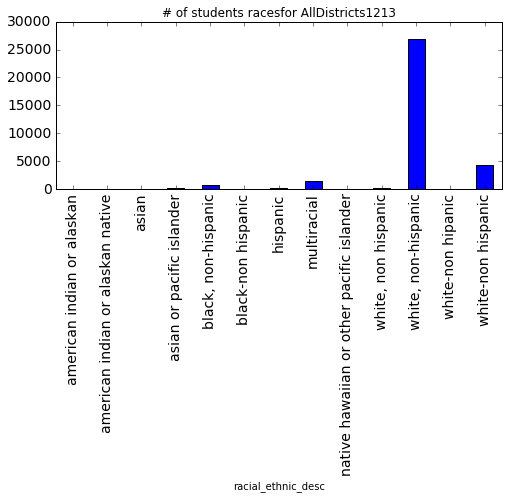

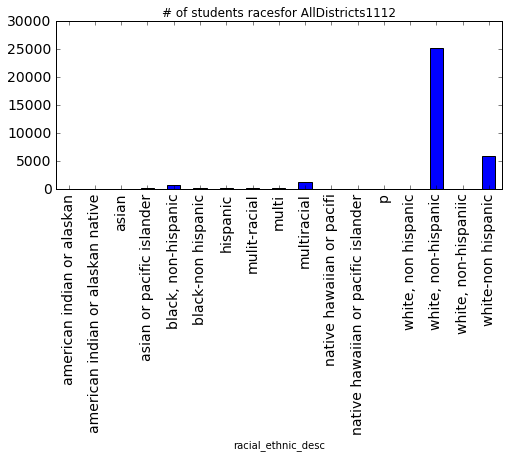

In [111]:
col='RACIAL_ETHNIC_DESC'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students races', out_rows=[''], figsize=(8, 3))
    
# what I learnt: 
# Questions: what are 'b', 'p', 'w'? black, pacific, white? could be a feature or not
# Cleanup: 'b'-> black, p-> pacific islander; pacific islander->asian/pacific islander

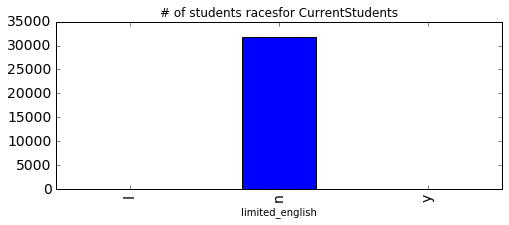

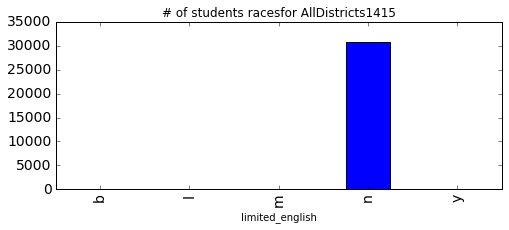

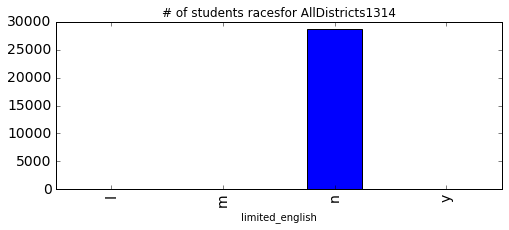

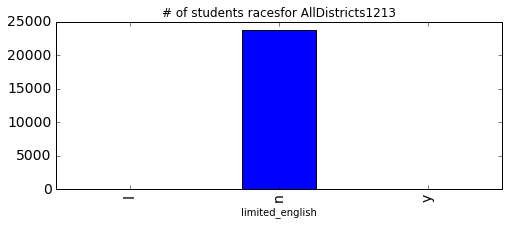

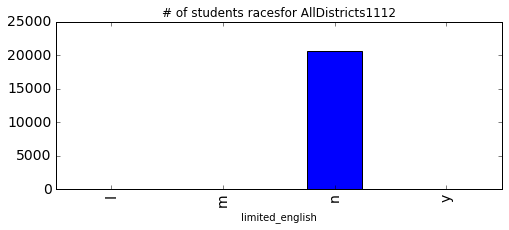

In [112]:
col='LIMITED_ENGLISH'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students Limited English', out_rows=[''], figsize=(8, 3))
    
# what I learnt: maybe not a useful feature 
# Questions: most of them are 'n'
# Cleanup: maybe we don't need this feature

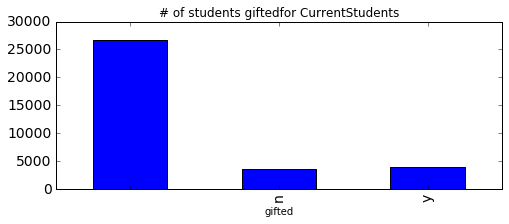

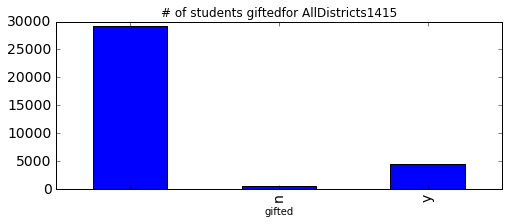

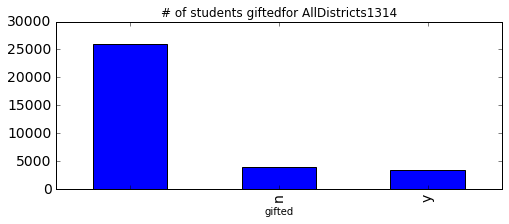

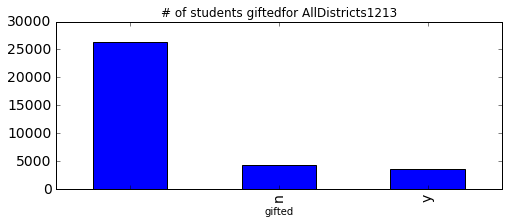

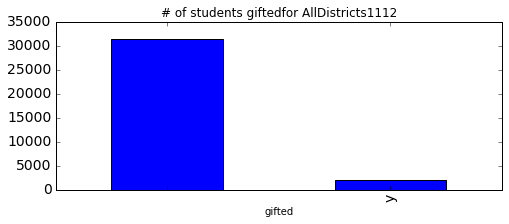

In [115]:
col='GIFTED'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students gifted', out_rows=['abc'], figsize=(8, 3))
    
# what I learnt: ~10% of them are gifted; it could be a feature, only 2 classes
# Questions: blank means 'No'
# Cleanup: blank -> 'n'

In [159]:
print("abc", "cd")

abc cd


In [161]:
def numeric_values_stats_attd_susp(table_index):
    print("\nTable Name:", ALL_DISTRICTS_TABLES[table_index])
    cols = all_districts_data[table_index].columns[14:-2]
    nRows = all_districts_data[table_index].shape[0]
    stat = [[all_districts_data[table_index][col].max(), all_districts_data[table_index][col].min(), all_districts_data[table_index][col].mean(), all_districts_data[table_index][col].isnull().sum(), 1.0*all_districts_data[table_index][col].isnull().sum()/nRows] for col in cols]
    stat = pd.DataFrame(stat, columns=['max', 'min', 'mean', 'num_of_NaN', 'Percent_NaN'], index=cols)
    return stat
numeric_values_stats_attd_susp(0)
numeric_values_stats_attd_susp(1)



Table Name: CurrentStudents


,max,min,mean,num_of_NaN,Percent_NaN
PERCENT_ATTEND_2014_15,102.1,0.0,94.658153,5886,0.171469
DAYS_IN_ATTENDANCE_2014_15,193.3,0.0,151.373862,7534,0.219477
DAYS_ABSENT_2014_15,105.5,-0.1,8.160955,5791,0.168701
TARDY_2014_15,66.0,0.0,3.076116,22319,0.650188
PERCENT_ATTEND_2013_14,100.0,0.0,95.150794,10838,0.315728
DAYS_IN_ATTENDANCE_2013_14,205.0,0.0,156.272543,10619,0.309348
DAYS_ABSENT_2013_14,136.5,0.0,7.807099,10639,0.309931
TARDY_2013_14,73.0,0.0,2.007154,12941,0.376992
DISC_INCIDENTS_2014_15,53.0,1.0,3.639384,31016,0.903545
IN_SCHOOL_SUSP_2014_15,8.0,1.0,1.641953,33774,0.983890


In [151]:
ALL_DISTRICTS_TABLES[1][-4:]

'1415'

In [145]:
all_districts_data[1].columns[14:-2]

Index(['PERCENT_ATTEND_2013_14', 'DAYS_IN_ATTENDANCE_2013_14',
       'DAYS_ABSENT_2013_14', 'TARDY_2013_14', 'PERCENT_ATTEND_2012_13',
       'DAYS_IN_ATTENDANCE_2012_13', 'DAYS_ABSENCT_2012_13', 'TARDY_2012_13',
       'DISC_INCIDENTS_2013_14', 'IN_SCHOOL_SUSP_2013_14',
       'OUT_OF_SCHOOL_SUSP_2013_14', 'EXPUL_2013_14'],
      dtype='object')

In [147]:
i=1
[[all_districts_data[i][col].max(), all_districts_data[i][col].min(), all_districts_data[i][col].mean(), all_districts_data[i][col].isnull().sum()] for col in cols ]

KeyError: 'DAYS_ABSENT_2012_13'

In [ ]:
DAYS_ABSENCT_2012_13